# Import all modules/libraries

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
from IPython.display import Image, Markdown
import seaborn as sns
plt.style.use('seaborn')
import difflib
from __future__ import print_function, division
import datetime
from datetime import datetime as dt
from scipy.ndimage.filters import generic_filter

%matplotlib inline

# Look at the key/description of the data

In [2]:
# Seems like UNIT or SUBUNIT could be a unique values 
# Seems like the audits are captured every four hours UNLESS the AUDITTYPE is NOT 'regular'
# The DATE column format is MM-DD-YY
# The TIME column format is hh:mm:ss 

turnstiles_key = open('/Users/NickThomas/Project_Benson/data/ts_Field_Description.txt','r') 

# Import all data as csvs

In [3]:
turnstiles_april_week1 = pd.read_csv('/Users/NickThomas/Project_Benson/data/turnstile_180407.txt')
turnstiles_march_week4 = pd.read_csv('/Users/NickThomas/Project_Benson/data/turnstile_180331.txt')
turnstiles_march_week3 = pd.read_csv('/Users/NickThomas/Project_Benson/data/turnstile_180324.txt')
turnstiles_march_week2 = pd.read_csv('/Users/NickThomas/Project_Benson/data/turnstile_180317.txt')

### Combine all text files to make one large csv 

In [4]:
turnstiles_fourweeks = [turnstiles_april_week1, turnstiles_march_week4, turnstiles_march_week3, turnstiles_march_week2]

In [5]:
turnstiles_df = pd.concat(turnstiles_fourweeks)

# Review the data

#### Look at the shape of the data

In [6]:
turnstiles_df.shape

(755250, 11)

#### View the top of the data

In [7]:
# Seems like most of the data is not intuitive without looking at the key
# We should look at the key to get a better understanding of what the unique values are
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2018,00:00:00,REGULAR,6566463.0,2224050.0
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2018,04:00:00,REGULAR,6566470.0,2224053.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2018,08:00:00,REGULAR,6566470.0,2224053.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2018,12:00:00,REGULAR,6566470.0,2224055.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2018,16:00:00,REGULAR,6566470.0,2224055.0


#### View the bottom of the data

In [8]:
# Looks like the ENTRIES and EXITS at the bottom of the dataframe are significantly smaller than at the top
turnstiles_df.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
195332,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,03/16/2018,05:00:00,REGULAR,2521594.0,28242.0
195333,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,03/16/2018,09:00:00,REGULAR,2521965.0,28242.0
195334,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,03/16/2018,13:00:00,REGULAR,2522337.0,28244.0
195335,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,03/16/2018,17:00:00,REGULAR,2522632.0,28247.0
195336,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,03/16/2018,21:00:00,REGULAR,2522844.0,28247.0


## Take a closer look at the column labels

In [9]:
# Seems like the 'EXITS' column label has extra spaces at the end
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

#### Fix the "EXITS" column label by removing the extra spaces and make the other labels more intiutive

In [10]:
# Couldn't figure how to use .strip() for inplace changes https://www.tutorialspoint.com/python/string_strip.htm
# Therefore, manually changed each of the items with a .rename()
# Using a for loop to iterate over the columns property of the turnstiles_df dataframe

turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

## Take a closer look at the datatypes

In [11]:
'''Seems like the only two items that might be dependent variables are ENTRIES and EXITS
    All but the ENTRIES and EXITS are objects. ENTRIES and EXITS are float 64
    Maybe we want to look into DATE and TIME to see if they can be converted for easier manipulation/exploration
    Looks like there is one null row for each of the following columns:
    TIME, DESC, ENTRIES, EXITS
    Therefore, we want to dropna
    '''

turnstiles_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 755250 entries, 0 to 195336
Data columns (total 11 columns):
C/A         755250 non-null object
UNIT        755250 non-null object
SCP         755250 non-null object
STATION     755250 non-null object
LINENAME    755250 non-null object
DIVISION    755250 non-null object
DATE        755250 non-null object
TIME        755249 non-null object
DESC        755249 non-null object
ENTRIES     755249 non-null float64
EXITS       755249 non-null float64
dtypes: float64(2), object(9)
memory usage: 69.1+ MB


In [12]:
'''We want to use 'all' in the how argument so that we do not drop the three columns that only have 1 na value
    Save a copy of the original data before storing the dataframe without the nas back into turnstiles_df'''

turnstiles_df_all = turnstiles_df
turnstiles_df = turnstiles_df.dropna(how = 'all')

#### Convert the TIME and DATE data to pandas datetime objects

In [13]:
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html
# https://stackoverflow.com/questions/36589020/conversion-of-dates-in-the-dataframe-column-into-mm-dd-yyyy

turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME, format="%m/%d/%Y %H:%M:%S")

In [14]:
turnstiles_df['DATES_FORMATTED'] = pd.to_datetime(turnstiles_df['DATE']).dt.strftime('%m/%d/%Y')

In [15]:
turnstiles_df['TIME_FORMATTED'] = pd.to_datetime(turnstiles_df['TIME']).dt.strftime('%H:%M:%S')

In [16]:
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS', 'DATE_TIME', 'DATES_FORMATTED',
       'TIME_FORMATTED'],
      dtype='object')

# Look closer at each of the columns of data to find potential anomalies

#### Check the value counts of station

In [17]:
'''There are 373 unique station strings. This does NOT mean those are unique station listings, as there may
be duplicates that are simply mis-spelled'''

turnstiles_df_bystation = turnstiles_df.STATION.value_counts().sort_values(ascending = False)
turnstiles_df_bystation.shape

(373,)

#### Check the value counts of dates

In [18]:
# The number of rows for each date seems to be consistent. So maybe there are no anomalies by date
turnstiles_df_datecount = turnstiles_df.DATES_FORMATTED.value_counts().sort_values(ascending = False)
turnstiles_df_datecount

03/12/2018    28575
03/13/2018    28493
04/05/2018    28262
03/10/2018    28220
03/15/2018    28198
04/03/2018    28189
03/14/2018    28184
04/04/2018    28154
03/24/2018    28143
03/27/2018    28137
03/16/2018    28135
03/31/2018    28129
04/06/2018    28121
03/25/2018    28117
03/28/2018    28100
03/29/2018    28085
04/01/2018    28084
03/30/2018    28059
04/02/2018    28049
03/26/2018    28013
03/11/2018    25532
03/17/2018    23866
03/18/2018    23783
03/21/2018    23778
03/20/2018    23767
03/22/2018    23725
03/19/2018    23687
03/23/2018    23665
Name: DATES_FORMATTED, dtype: int64

# FILTER NOTICE 

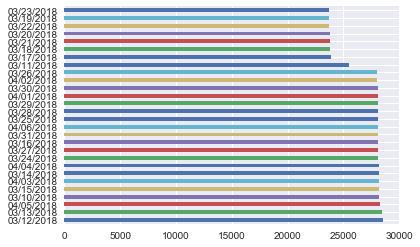

In [19]:
'''To investigate so that we don't just eyeball it, we created a barchart. 
From the barchart, we gather that there seems to be an anomaly with the date range 3/11 and 3/17-3/23, as those dates have less than average, 
but around the same count of rows
We should see if these dates are flagged across other variable counts as well. According to the series we 
generated previously, 28,000 is the cutoff. We should make a list of the dates that are less than this cutoff.
'''
turnstiles_df_datecount.plot.barh()

## Define a function to filter by datecount < 28000

In [20]:
def remove_dates_func(date):
    if date < 28000:
        return date

In [21]:
remove_dates_series = (turnstiles_df_datecount.apply(remove_dates_func)).dropna()
remove_dates_list = list(remove_dates_series.keys())
remove_dates_list

['03/11/2018',
 '03/17/2018',
 '03/18/2018',
 '03/21/2018',
 '03/20/2018',
 '03/22/2018',
 '03/19/2018',
 '03/23/2018']

#### Check the value counts and distribution of time

In [22]:
'''Looks like there are a lot of time values that only have one associated entry. We should be able to remove those.
Let us take a closer look'''

turnstiles_df_timecount = turnstiles_df.TIME_FORMATTED.value_counts().sort_values(ascending = True)
turnstiles_df_timecount

23:30:50        1
07:41:59        1
10:38:34        1
19:31:43        1
11:23:36        1
12:11:35        1
22:00:52        1
10:34:49        1
05:27:34        1
19:20:07        1
14:13:31        1
15:43:11        1
16:26:48        1
16:27:28        1
12:48:09        1
08:45:49        1
07:28:30        1
22:04:31        1
04:01:31        1
21:57:48        1
23:32:55        1
02:19:22        1
09:12:45        1
22:51:24        1
08:05:04        1
22:39:21        1
02:39:02        1
17:46:15        1
00:04:56        1
12:37:24        1
            ...  
00:22:00      961
04:22:00      985
20:22:00      992
12:22:00      994
08:22:00      998
16:22:00      999
02:00:00     2850
06:00:00     2947
14:00:00     2956
10:00:00     2958
22:00:00     2960
18:00:00     2962
23:00:00     3467
19:00:00     3475
07:00:00     3491
11:00:00     3494
03:00:00     3494
15:00:00     3499
01:00:00    43050
17:00:00    44638
13:00:00    44655
09:00:00    44661
21:00:00    44696
05:00:00    44702
00:00:00  

# FILTER NOTICE

#### Plot the timecounts

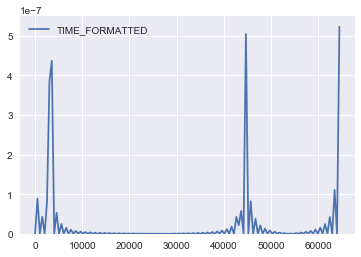

In [23]:
'''The kde plot suggests that the outliers are around the 1 to 5000 rows range. 
Since there should be one audit per every 4 hour timeframe per day per station, and there are 
at most 373 unique stations (we don't know if there are dupes) we would expect there to be at least 373 rows per time_formatted
Therefore, we can probably filter out any rows with a  time_formatted value that has less than 373 associated value counts ''' 

sns.kdeplot(turnstiles_df_timecount)

## Define a function to filter by timecount < 40000

In [24]:
def remove_time_func(time):
    if time < 4000:
        return time

In [25]:
remove_time_series = (turnstiles_df_timecount.apply(remove_time_func)).dropna()
remove_time_list = list(remove_time_series.keys())
remove_time_list

['23:30:50',
 '07:41:59',
 '10:38:34',
 '19:31:43',
 '11:23:36',
 '12:11:35',
 '22:00:52',
 '10:34:49',
 '05:27:34',
 '19:20:07',
 '14:13:31',
 '15:43:11',
 '16:26:48',
 '16:27:28',
 '12:48:09',
 '08:45:49',
 '07:28:30',
 '22:04:31',
 '04:01:31',
 '21:57:48',
 '23:32:55',
 '02:19:22',
 '09:12:45',
 '22:51:24',
 '08:05:04',
 '22:39:21',
 '02:39:02',
 '17:46:15',
 '00:04:56',
 '12:37:24',
 '11:42:46',
 '03:24:42',
 '02:47:44',
 '17:03:44',
 '12:47:44',
 '08:17:11',
 '17:08:35',
 '15:15:21',
 '16:58:53',
 '05:18:33',
 '09:27:41',
 '20:18:03',
 '21:27:20',
 '15:45:10',
 '06:25:50',
 '21:16:20',
 '08:04:29',
 '16:50:47',
 '23:53:56',
 '00:12:43',
 '17:08:22',
 '16:23:31',
 '08:41:16',
 '10:41:40',
 '21:43:03',
 '13:27:57',
 '08:24:08',
 '04:40:54',
 '21:08:11',
 '12:01:22',
 '12:13:24',
 '08:19:07',
 '00:49:24',
 '18:21:00',
 '15:53:32',
 '07:41:31',
 '13:46:09',
 '01:12:27',
 '02:47:12',
 '21:27:09',
 '08:23:22',
 '20:03:48',
 '23:36:42',
 '20:22:58',
 '06:32:21',
 '18:52:29',
 '15:50:29',

# FILTER NOTICE
### Check audit type value counts

In [26]:
# It seems like relative to the regular entries, there are very few recovery audits
# We should probably investigate what those recovery entries are doing and then filter them out 
turnstiles_df_auditcount = turnstiles_df.DESC.value_counts().sort_values(ascending = False)

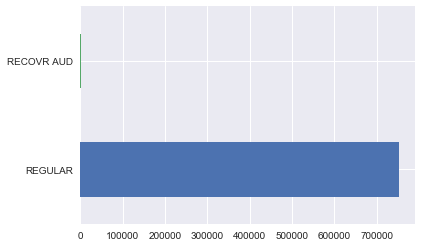

In [27]:
turnstiles_df_auditcount.plot.barh()

# Apply all the filters we decided on to the dataframe
Don't worry, we already a copy of the original data.
1. Remove rows that were taken on any of the following dates: 3/11, 3/17 - 3/23 (range inclusive). That is because they had lower than normal rowscounts, suggesting that the audits were non-standards and thus could throw off aggregates we're trying to build with the entries and exits.
2. Remove rows that have a TIME value that is within the turnstiles_df_timecount and is a value < 373. That is because those are abnormal timeblocks (outside of the regular 4 hr blocks) to take audits and there being less rows than there are maximum unique stations suggests they would not be applicable to the aggregates we're building with entries and exits. 
3. Remove the reovery audits. Same reasoning as the aforementioned second filter. 

# APPLY FILTER 1: Remove rows based on turnstiles_df_datecount < 28000

In [28]:
# Don't worry, we already created a copy of the original dataframe
turnstiles_df = turnstiles_df[-turnstiles_df.DATES_FORMATTED.isin(remove_dates_list)]

#### Check that it definitely change the dataframe

In [29]:
# Resulted in removing 191803 rows, since the total was 755250 rows before we filtered anything 
# Double-checking that it worked on the actual dataframe, see if the rowcount matches the rowcount output from filtering
turnstiles_df.shape

(563447, 14)

# APPLY FILTER 2: Remove rows based on turnstiles_df_timecount < 373

In [30]:
turnstiles_df = turnstiles_df[-turnstiles_df.TIME_FORMATTED.isin(remove_time_list)]

#### Check that it definitely changed the dataframe

In [31]:
# Resulted in removing 77824 rows, since the total was 563447 rows after filtering by dates 
turnstiles_df.shape

(485623, 14)

# APPLY FILTER 3: Remove rows with DESC = RECOVR AUD

In [32]:
# Resulted in removing 1354 rows, since the total was 485623 rows after filtering by timecount
turnstiles_df = turnstiles_df.loc[turnstiles_df['DESC'] != 'RECOVR AUD']

#### Check that it definitely changed the dataframe

In [33]:
turnstiles_df.STATION.nunique()

354

# Find which datapoint can be the unique id for the rows 

### Apply the class hypothesis first

In [34]:
'''The class believed that the combination of C/A, UNIT, SCP, STATION, and DATE is the unique identifier
I believe that there might actually be duplicate station names. In which case, we would be separating their entries
and exits across two or more groups. I want to investigate this, but I will start analyzing using the class hypothesis
'''
turnstiles_df_unique_classhyp_daily = turnstiles_df.groupby(['C/A','UNIT', 'SCP','STATION', 'DATE']).ENTRIES.first().reset_index()
turnstiles_df_unique_classhyp_daily

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,03/12/2018,6545250.0
1,A002,R051,02-00-00,59 ST,03/13/2018,6546681.0
2,A002,R051,02-00-00,59 ST,03/14/2018,6548069.0
3,A002,R051,02-00-00,59 ST,03/15/2018,6549577.0
4,A002,R051,02-00-00,59 ST,03/16/2018,6551059.0
5,A002,R051,02-00-00,59 ST,03/24/2018,6559322.0
6,A002,R051,02-00-00,59 ST,03/25/2018,6559565.0
7,A002,R051,02-00-00,59 ST,03/26/2018,6559579.0
8,A002,R051,02-00-00,59 ST,03/27/2018,6560941.0
9,A002,R051,02-00-00,59 ST,03/28/2018,6562409.0


In [35]:
turnstiles_df_unique_classhyp_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_df_unique_classhyp_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       .transform(lambda grp: grp.shift(1)))

In [36]:
# It makes sense that the first row has NaN for previous date and previous entry, since that is the first datetime of our data
turnstiles_df_unique_classhyp_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,03/12/2018,6545250.0,NaN,NaN
1,A002,R051,02-00-00,59 ST,03/13/2018,6546681.0,03/12/2018,6545250.0
2,A002,R051,02-00-00,59 ST,03/14/2018,6548069.0,03/13/2018,6546681.0
3,A002,R051,02-00-00,59 ST,03/15/2018,6549577.0,03/14/2018,6548069.0
4,A002,R051,02-00-00,59 ST,03/16/2018,6551059.0,03/15/2018,6549577.0


In [37]:
# Drop the rows for the last date
turnstiles_df_unique_classhyp_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

# ANOMALY NOTICE

### Investigate whether there are anamolies in the direction of entries accumulation

In [38]:
# It seems like there are entries that 
turnstiles_df_unique_classhyp_daily[turnstiles_df_unique_classhyp_daily["ENTRIES"] < turnstiles_df_unique_classhyp_daily["PREV_ENTRIES"]].head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
395,A011,R080,01-00-00,57 ST-7 AV,03/13/2018,886086179.0,03/12/2018,886089739.0
396,A011,R080,01-00-00,57 ST-7 AV,03/14/2018,886082576.0,03/13/2018,886086179.0
397,A011,R080,01-00-00,57 ST-7 AV,03/15/2018,886078703.0,03/14/2018,886082576.0
398,A011,R080,01-00-00,57 ST-7 AV,03/16/2018,886074875.0,03/15/2018,886078703.0
399,A011,R080,01-00-00,57 ST-7 AV,03/24/2018,886049706.0,03/16/2018,886074875.0


### Check how many stations have this problem

In [39]:
(turnstiles_df_unique_classhyp_daily[turnstiles_df_unique_classhyp_daily["ENTRIES"] < turnstiles_df_unique_classhyp_daily["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
     .size())

C/A    UNIT  SCP       STATION        
A011   R080  01-00-00  57 ST-7 AV         18
A025   R023  01-03-01  34 ST-HERALD SQ    18
             01-03-02  34 ST-HERALD SQ    11
A035   R170  00-00-01  14 ST-UNION SQ      1
A049   R088  02-05-00  CORTLANDT ST       17
A066   R118  00-00-00  CANAL ST           19
C021   R212  00-00-02  59 ST              18
D011   R394  01-06-00  BAY PKWY           19
             01-06-01  BAY PKWY           19
D016   R397  00-00-01  86 ST               1
H003   R163  01-00-02  6 AV               18
H023   R236  00-06-00  DEKALB AV          18
H028   R266  00-06-00  HALSEY ST           1
J034   R007  00-00-02  104 ST             18
JFK03  R536  00-03-03  JFK JAMAICA CT1     1
K026   R100  00-00-01  METROPOLITAN AV    18
N063A  R011  00-00-04  42 ST-PORT AUTH    18
             00-00-05  42 ST-PORT AUTH    18
             00-00-08  42 ST-PORT AUTH    18
N078   R175  01-03-00  14 ST              19
N094   R029  01-00-04  WORLD TRADE CTR     1
N137   R354  00-

## Write a function to address the anomaly

In [40]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # May be counter is reversed?
        counter = -counter
    if counter > max_counter:
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we are not giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits

### Run the function
Apply the function it to each of the rows in the dataframe. Store the results into a new column in the dataframe. 

In [41]:
turnstiles_df_unique_classhyp_daily["DAILY_ENTRIES"] = turnstiles_df_unique_classhyp_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

371.0 2730447.0
1900738.0 18599.0
237.0 3136706.0
526074.0 5581708.0
1110.0 7331460.0
2600.0 8641917.0
173.0 4396791.0
15462.0 5505351.0
620780454.0 2448653.0
8593.0 3212126.0
2680.0 6630362.0
510.0 2687359.0
1185.0 9906513.0
4017946.0 509589.0
509793.0 4016587.0


### Review the results

In [42]:
'''Validate that there are no negative daily entries, seeing as you ordered ascending, the top would have negative values if there were any'''
turnstiles_df_unique_classhyp_daily_entriescount = turnstiles_df_unique_classhyp_daily.DAILY_ENTRIES.sort_values(ascending = True)
turnstiles_df_unique_classhyp_daily_entriescount

53385         0.0
40225         0.0
40231         0.0
40232         0.0
40233         0.0
40234         0.0
40235         0.0
40236         0.0
40237         0.0
40238         0.0
40239         0.0
40240         0.0
40241         0.0
40242         0.0
40243         0.0
40244         0.0
40245         0.0
40246         0.0
40247         0.0
40248         0.0
67604         0.0
67605         0.0
40255         0.0
40256         0.0
40262         0.0
40263         0.0
67606         0.0
67607         0.0
67603         0.0
67602         0.0
           ...   
21362     37936.0
61356     38590.0
52242     38863.0
21229     39008.0
60852     39744.0
47069     39798.0
58723     40397.0
47088     41046.0
71817     41139.0
24260     43054.0
13670     45474.0
1906      45475.0
21210     50641.0
61376     51631.0
60909     54272.0
60871     55977.0
25344    114636.0
54203    120085.0
63694    183502.0
32082    186517.0
14815    199173.0
2166     211539.0
80958    329609.0
80998    331211.0
32257    4

# Start aggregating data to plot

## Group by station, aggregate by daily entries

In [43]:
turnstiles_df_unique_classhyp_daily_bystation = turnstiles_df_unique_classhyp_daily.groupby(["STATION"]).agg({'DAILY_ENTRIES': 'sum'})


In [44]:
turnstiles_df_unique_classhyp_daily_bystation

,DAILY_ENTRIES
STATION,
1 AV,504290.0
103 ST,882594.0
103 ST-CORONA,439795.0
104 ST,66863.0
110 ST,234751.0
111 ST,367597.0
116 ST,731659.0
116 ST-COLUMBIA,350389.0
121 ST,25880.0


In [45]:
# turnstiles_df_unique_classhyp_daily_bystation = turnstiles_df_unique_classhyp_daily.groupby(["STATION"]).agg({'DAILY_ENTRIES':sum}).sort_values("DAILY_ENTRIES", ascending = False).reset_index()
# turnstiles_df_unique_classhyp_daily_bystation

### Plot the data

### Try using the 75% quantile

In [46]:
turnstiles_df_unique_classhyp_daily_bystation_75quantile = turnstiles_df_unique_classhyp_daily_bystation['DAILY_ENTRIES'].quantile(0.75)
turnstiles_df_unique_classhyp_daily_bystation_75quantile

388486.25

In [47]:
turnstiles_df_unique_classhyp_daily_bystation_75quantile_filtered = turnstiles_df_unique_classhyp_daily_bystation[turnstiles_df_unique_classhyp_daily_bystation['DAILY_ENTRIES'] >=turnstiles_df_unique_classhyp_daily_bystation_75quantile].sort_values('DAILY_ENTRIES', ascending = True)

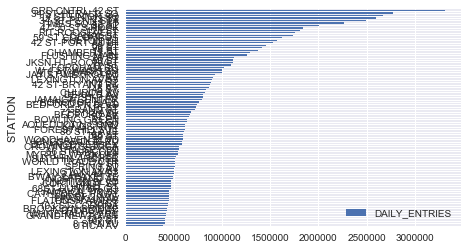

In [48]:
# Looks like there are too many stations represented to make sense of. 
# Narrow down further 
turnstiles_df_unique_classhyp_daily_bystation_75quantile_filtered.plot.barh()

### Try the 90th percentile

In [49]:
turnstiles_df_unique_classhyp_daily_bystation_90quantile = turnstiles_df_unique_classhyp_daily_bystation['DAILY_ENTRIES'].quantile(0.90)
turnstiles_df_unique_classhyp_daily_bystation_90quantile

802910.9

In [50]:
turnstiles_df_unique_classhyp_daily_bystation_90quantile_filtered = turnstiles_df_unique_classhyp_daily_bystation[turnstiles_df_unique_classhyp_daily_bystation['DAILY_ENTRIES'] >=turnstiles_df_unique_classhyp_daily_bystation_90quantile].sort_values('DAILY_ENTRIES', ascending = True).reset_index()
turnstiles_df_unique_classhyp_daily_bystation_90quantile_filtered

,STATION,DAILY_ENTRIES
0,DEKALB AV,806699.0
1,CHURCH AV,817899.0
2,145 ST,833225.0
3,8 AV,869460.0
4,42 ST-BRYANT PK,871658.0
5,103 ST,882594.0
6,LEXINGTON AV/53,897523.0
7,7 AV,904623.0
8,JAY ST-METROTEC,928541.0
9,ATL AV-BARCLAY,994897.0


# PRESENTATION GRAPH NOTICE

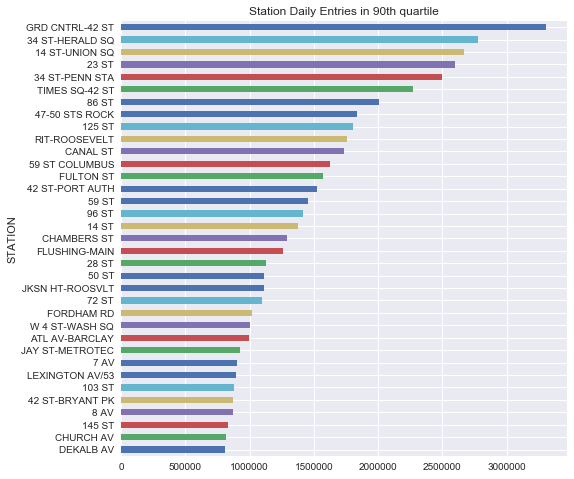

In [51]:
# The 90th percentile has a lot more management a range of stations to reference
turnstiles_df_unique_classhyp_daily_bystation_90quantile_filtered.plot.barh(x = 'STATION', y = 'DAILY_ENTRIES', figsize = (8, 8), legend = False, sharex = True, title = 'Station Daily Entries in 90th quartile')

# Apply the Ph.d data as a mask

The Ph.d data was obtained as a subset of the 2012-16 census dataset of Ph.d holders in NYC. The subset was defined as the top 35 stations based on the total number of Ph.d holders that resided within the zipcode of that station. The station to zip code mapping was done by hand via Google maps. 

In [52]:
smart_stations = ["CATHEDRAL PKWY", "103 ST", "96 ST", "96 ST-2 AVE", "86 ST", "86 ST-2 AVE", "79 ST", "81st", 
                  "72 ST", "72 ST-2 AVE", "66 ST-LINCOLN", "77 ST", "67 AV", "FOREST HILLS 71", "75 AV", "1 AV",
                 "3 AV", "ASTOR PL", "W 4 ST-WASH SQ", "B'WAY-LAFAYETTE", "PRINCE ST", "SPRING ST", "23 ST", "18 ST",
                 "14 ST", "UNION ST", "4 AV-9 ST", "9TH STREET", "7 AV", "PROSPECT AV", "15 ST-PROSPECT", "LEXINGTON AV/63", 
                 "59 ST COLUMBUS", "59 ST", "5 AV/59 ST", "LEXINGTON AV/53"]
turnstiles_df_unique_classhyp_daily_smart_stations_mask = turnstiles_df_unique_classhyp_daily.STATION.isin(smart_stations)
turnstiles_df_unique_classhyp_daily_phd = turnstiles_df_unique_classhyp_daily[turnstiles_df_unique_classhyp_daily_smart_stations_mask]

In [53]:
turnstiles_df_unique_classhyp_daily_phd

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,03/13/2018,6546681.0,03/12/2018,6545250.0,1431.0
2,A002,R051,02-00-00,59 ST,03/14/2018,6548069.0,03/13/2018,6546681.0,1388.0
3,A002,R051,02-00-00,59 ST,03/15/2018,6549577.0,03/14/2018,6548069.0,1508.0
4,A002,R051,02-00-00,59 ST,03/16/2018,6551059.0,03/15/2018,6549577.0,1482.0
5,A002,R051,02-00-00,59 ST,03/24/2018,6559322.0,03/16/2018,6551059.0,8263.0
6,A002,R051,02-00-00,59 ST,03/25/2018,6559565.0,03/24/2018,6559322.0,243.0
7,A002,R051,02-00-00,59 ST,03/26/2018,6559579.0,03/25/2018,6559565.0,14.0
8,A002,R051,02-00-00,59 ST,03/27/2018,6560941.0,03/26/2018,6559579.0,1362.0
9,A002,R051,02-00-00,59 ST,03/28/2018,6562409.0,03/27/2018,6560941.0,1468.0
10,A002,R051,02-00-00,59 ST,03/29/2018,6563880.0,03/28/2018,6562409.0,1471.0


### Groupby station and aggregate by sum of daily entries

In [54]:
turnstiles_df_unique_classhyp_daily_phd_bystation = turnstiles_df_unique_classhyp_daily_phd.groupby(["STATION"]).agg({'DAILY_ENTRIES': 'sum'})


In [55]:
turnstiles_df_unique_classhyp_daily_phd_bystation = turnstiles_df_unique_classhyp_daily_phd_bystation.groupby(["STATION"]).agg({'DAILY_ENTRIES':sum}).sort_values("DAILY_ENTRIES", ascending = False).reset_index()
turnstiles_df_unique_classhyp_daily_phd_bystation

,STATION,DAILY_ENTRIES
0,23 ST,2599280.0
1,86 ST,2004039.0
2,59 ST COLUMBUS,1625464.0
3,59 ST,1453860.0
4,96 ST,1418473.0
5,14 ST,1374810.0
6,72 ST,1092870.0
7,W 4 ST-WASH SQ,1002447.0
8,7 AV,904623.0
9,LEXINGTON AV/53,897523.0


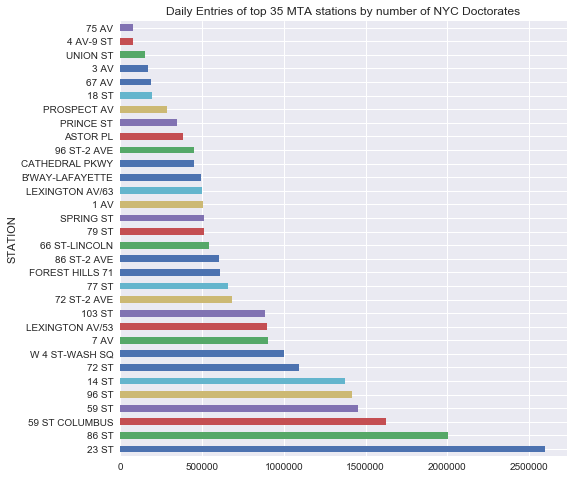

In [56]:
turnstiles_df_unique_classhyp_daily_phd_bystation.plot.barh(x = 'STATION', y = 'DAILY_ENTRIES', figsize = (8,8), legend = False, title = 'Daily Entries of top 35 MTA stations by number of NYC Doctorates')

In [57]:
unique_phd = list(turnstiles_df_unique_classhyp_daily_phd_bystation.STATION.unique())
unique_90th = list(turnstiles_df_unique_classhyp_daily_bystation_90quantile_filtered.STATION.unique())
unique_filter = list(set(unique_phd).intersection(unique_90th))

In [58]:
unique_mask = turnstiles_df_unique_classhyp_daily.STATION.isin(unique_filter)

In [59]:
unique_df = turnstiles_df_unique_classhyp_daily[unique_mask]

In [60]:
unique_df_groupbystation = unique_df.groupby(['STATION']).agg({'DAILY_ENTRIES':sum}).sort_values("DAILY_ENTRIES", ascending = False).reset_index()

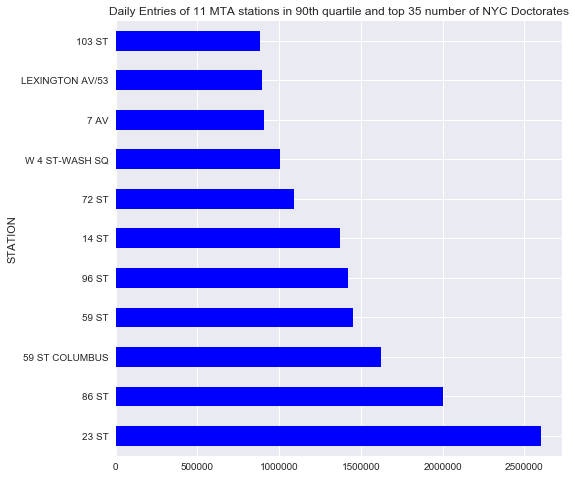

In [68]:
unique_df_groupbystation.plot.barh(x = 'STATION', y = 'DAILY_ENTRIES', figsize = (8,8), color='blue', legend = False, title = 'Daily Entries of 11 MTA stations in 90th quartile and top 35 number of NYC Doctorates')

# OPTIONAL: Validate my hypothesis that there are duplicate station names. Check if there seem to be any duplicate station names (ie: similar string)

The hypothesis is that the station can be a unique value we can plot (since there is a specific address for stations) 

In [63]:
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.unique.html
# Seems like there are multiple listings for the same stations
# Need to look up whether there are actually multiple stations -example(103 st versus 103 st-corona)

unique_stations_list_turnstile = list(turnstiles_df.STATION.unique())
sorted(unique_stations_list_turnstile)
unique_stations_list_turnstile.shape

AttributeError: 'list' object has no attribute 'shape'

### Cross validate your hypothesis that there are duplicate STATION names with the MTA entrance and exit dataset

#### Import the subway entrance/exit data csv

In [ ]:
entrance_exit_loc = pd.read_csv('NYC_Transit_Subway_Entrance_And_Exit_Data.csv')

#### View the first view lines of the entrance/exit data 

In [ ]:
entrance_exit_loc.head()

#### View the columns of the entrance/exit data

In [ ]:
# Everything looks formatted properly (ie: no extra spaces on the ends)
# Notice that the names have spaces in them, therefore, when calling them, you can't use the dot operator

entrance_exit_loc.columns

#### Obtain all of the unique station names from the entrance/exit data and sort them

In [ ]:
unique_stations_list_entrexit = sorted(list(entrance_exit_loc['Station Name'].unique()))

### Cross validate that the unique stations list from each dataset match each other

In [ ]:
# There seem to be stations listed in the turnstiles data that aren't listed in the entrance/exit data
# Since they do not match, probably want to see if there are similarities between the items in this delta list and the turnstiles stations list
# https://stackoverflow.com/questions/3462143/get-difference-between-two-lists

delta_unique_stations = list(set(unique_stations_list_turnstile) - set(unique_stations_list_entrexit))

In [ ]:
sorted_list = sorted(unique_stations_list_turnstile)
sorted_list

### Check if there are similarities between the station delta and the turnstiles station lists

In [ ]:
# Since there seems to always be at least 4 characters (including a space), we can use regex within loop over both lists
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.contains.html
# http://jonathansoma.com/lede/algorithms-2017/classes/fuzziness-matplotlib/fuzzing-matching-in-pandas-with-fuzzywuzzy/
# https://pymotw.com/2/difflib/
# '- ' indicates the difference is in the first list. In this case, the letters "Julian".

# '+ ' indicates the difference is in the second list. In this case, the letters "Bob".

# '? ' draws your attention to anything that doesn't appear in either list. It appears under every line here (except the last) because the new line we inserted wasn't originally there.

# ' ' (a blank space) indicates that this line is a perfect match and is in both lists. 

# Combine the delta list and the turnstile station lists into one list 
delta_and_turnstile_stations = delta_unique_stations + unique_stations_list_turnstile

for station in delta_and_turnstile_stations:
    process.extract(station, 

### Filter the turnstile data by the stations that are listed in the delta list

In [ ]:
# The data suggests that there are multiple station names associated to one unit, but the subunits are unique
# This suggests that maybe there are similar station names that are typos OR that entrances/exits are listed as different station names in the turnstile data
stations_turnstile_only = turnstiles_df[turnstiles_df['STATION'].isin(delta_unique_stations)] 
stations_turnstile_only.head()
stations_turnstile_only_grouped = stations_turnstile_only.groupby(['UNIT', 'STATION', 'SUBUNIT']).agg({'ENTRIES':sum})
stations_turnstile_only_grouped

## Based on those findings, I believe that Unit-Subunit-DateTime is the actual unique identifier for a row in the dataframe

### Groupby unit-subunit-datetime to obtain the unique identifier 

In [ ]:
turnstiles_df = .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"]).ENTRIES.count().reset_index().sort_values("ENTRIES", ascending=False)

In [ ]:
def closeMatches(patterns, word):
     print(get_close_matches(word, patterns)) 

def matchbyfour(list1, list2):
    for item in list1:
        
    return 

# OPTIONAL: Validate the statistical significance of our findings 